### Problem

Predict the presence or absence of cardiovascular disease (CVD) using the patient examination results.

### Data description

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

Let's get to know our data by performing a preliminary data analysis.

In [1]:
# Import all required modules
# Disable warnings
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# Import plotting modules and set up
import seaborn as sns

sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", font_scale=1.5, rc={"figure.figsize": (11, 8), "axes.titlesize": 18}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

In [3]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [4]:
df = pd.read_csv(DATA_PATH + "mlbootcamp5_train.csv", sep=";")
print("Dataset size: ", df.shape)

Dataset size:  (70000, 13)


In [5]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Let's convert the data into long format and depict the value counts of the categorical features using catplot().

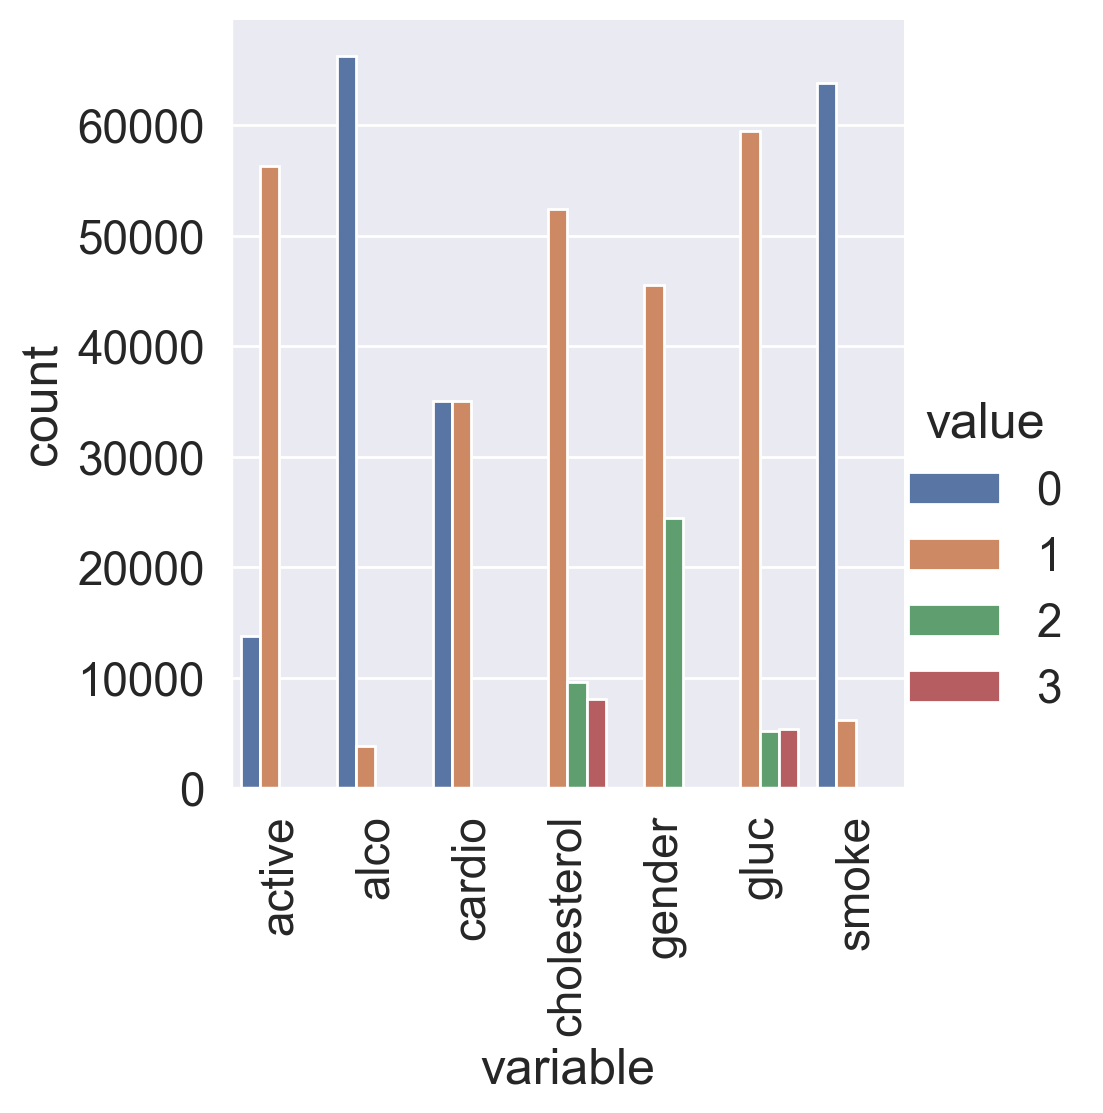

In [6]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.catplot(
    x="variable", y="count", hue="value", data=df_uniques, kind="bar"
)
plt.xticks(rotation='vertical');

Let's split the dataset by target values.

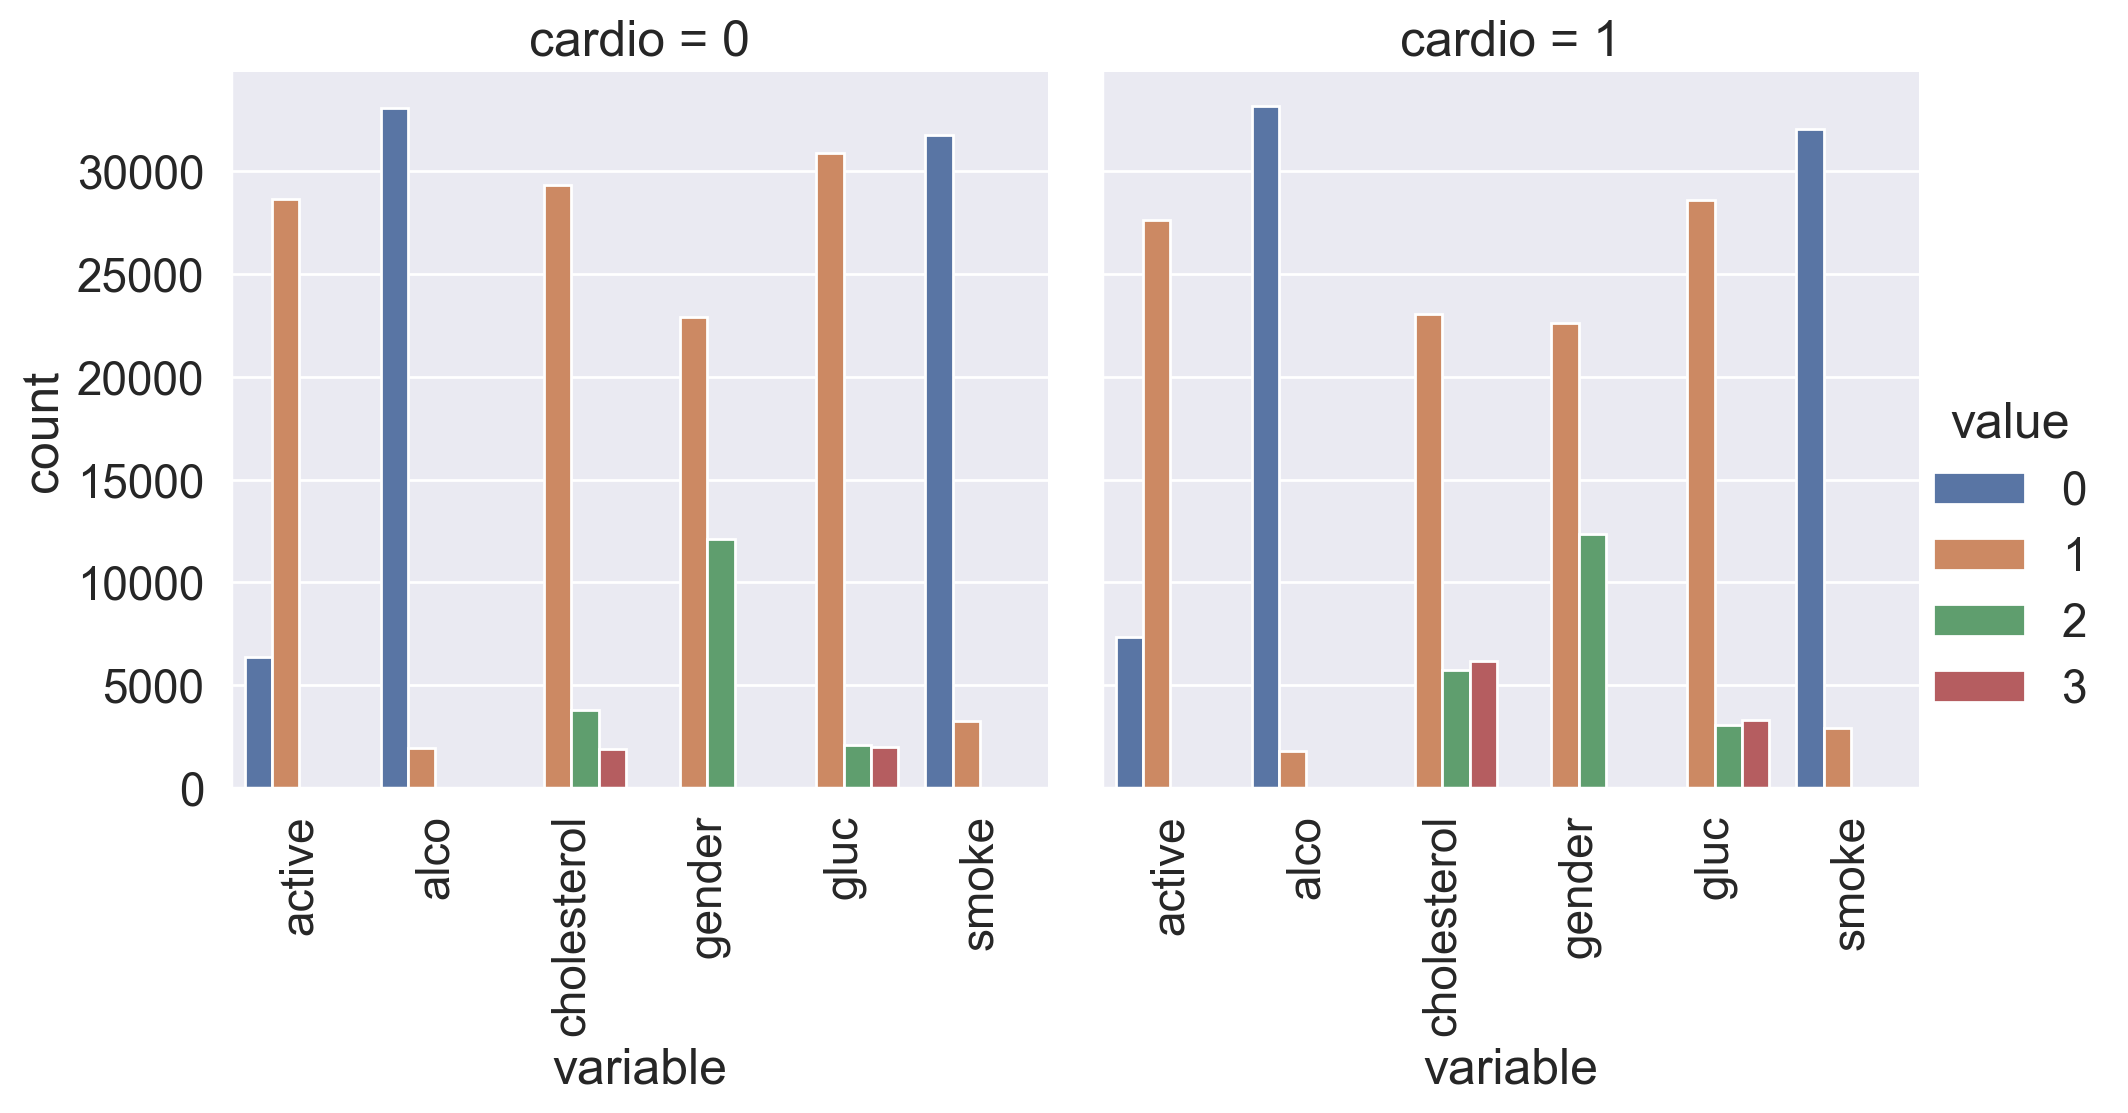

In [7]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active"],
    id_vars=["cardio"],
)

df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value", "cardio"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

g = sns.catplot(
    x="variable",
    y="count",
    hue="value",
    col="cardio",
    data=df_uniques,
    kind="bar",
)
#plt.xticks(rotation='vertical');
g.set_xticklabels(rotation='vertical');

You can see that the distribution of cholesterol and glucose levels great differs by the value of the target variable.

## 1.1. Basic observations

**Question 1.1. How many men and women are present in this dataset? Values of the `gender` feature were not given (whether "1" stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average.**

Let's create two distplots for both genders. 

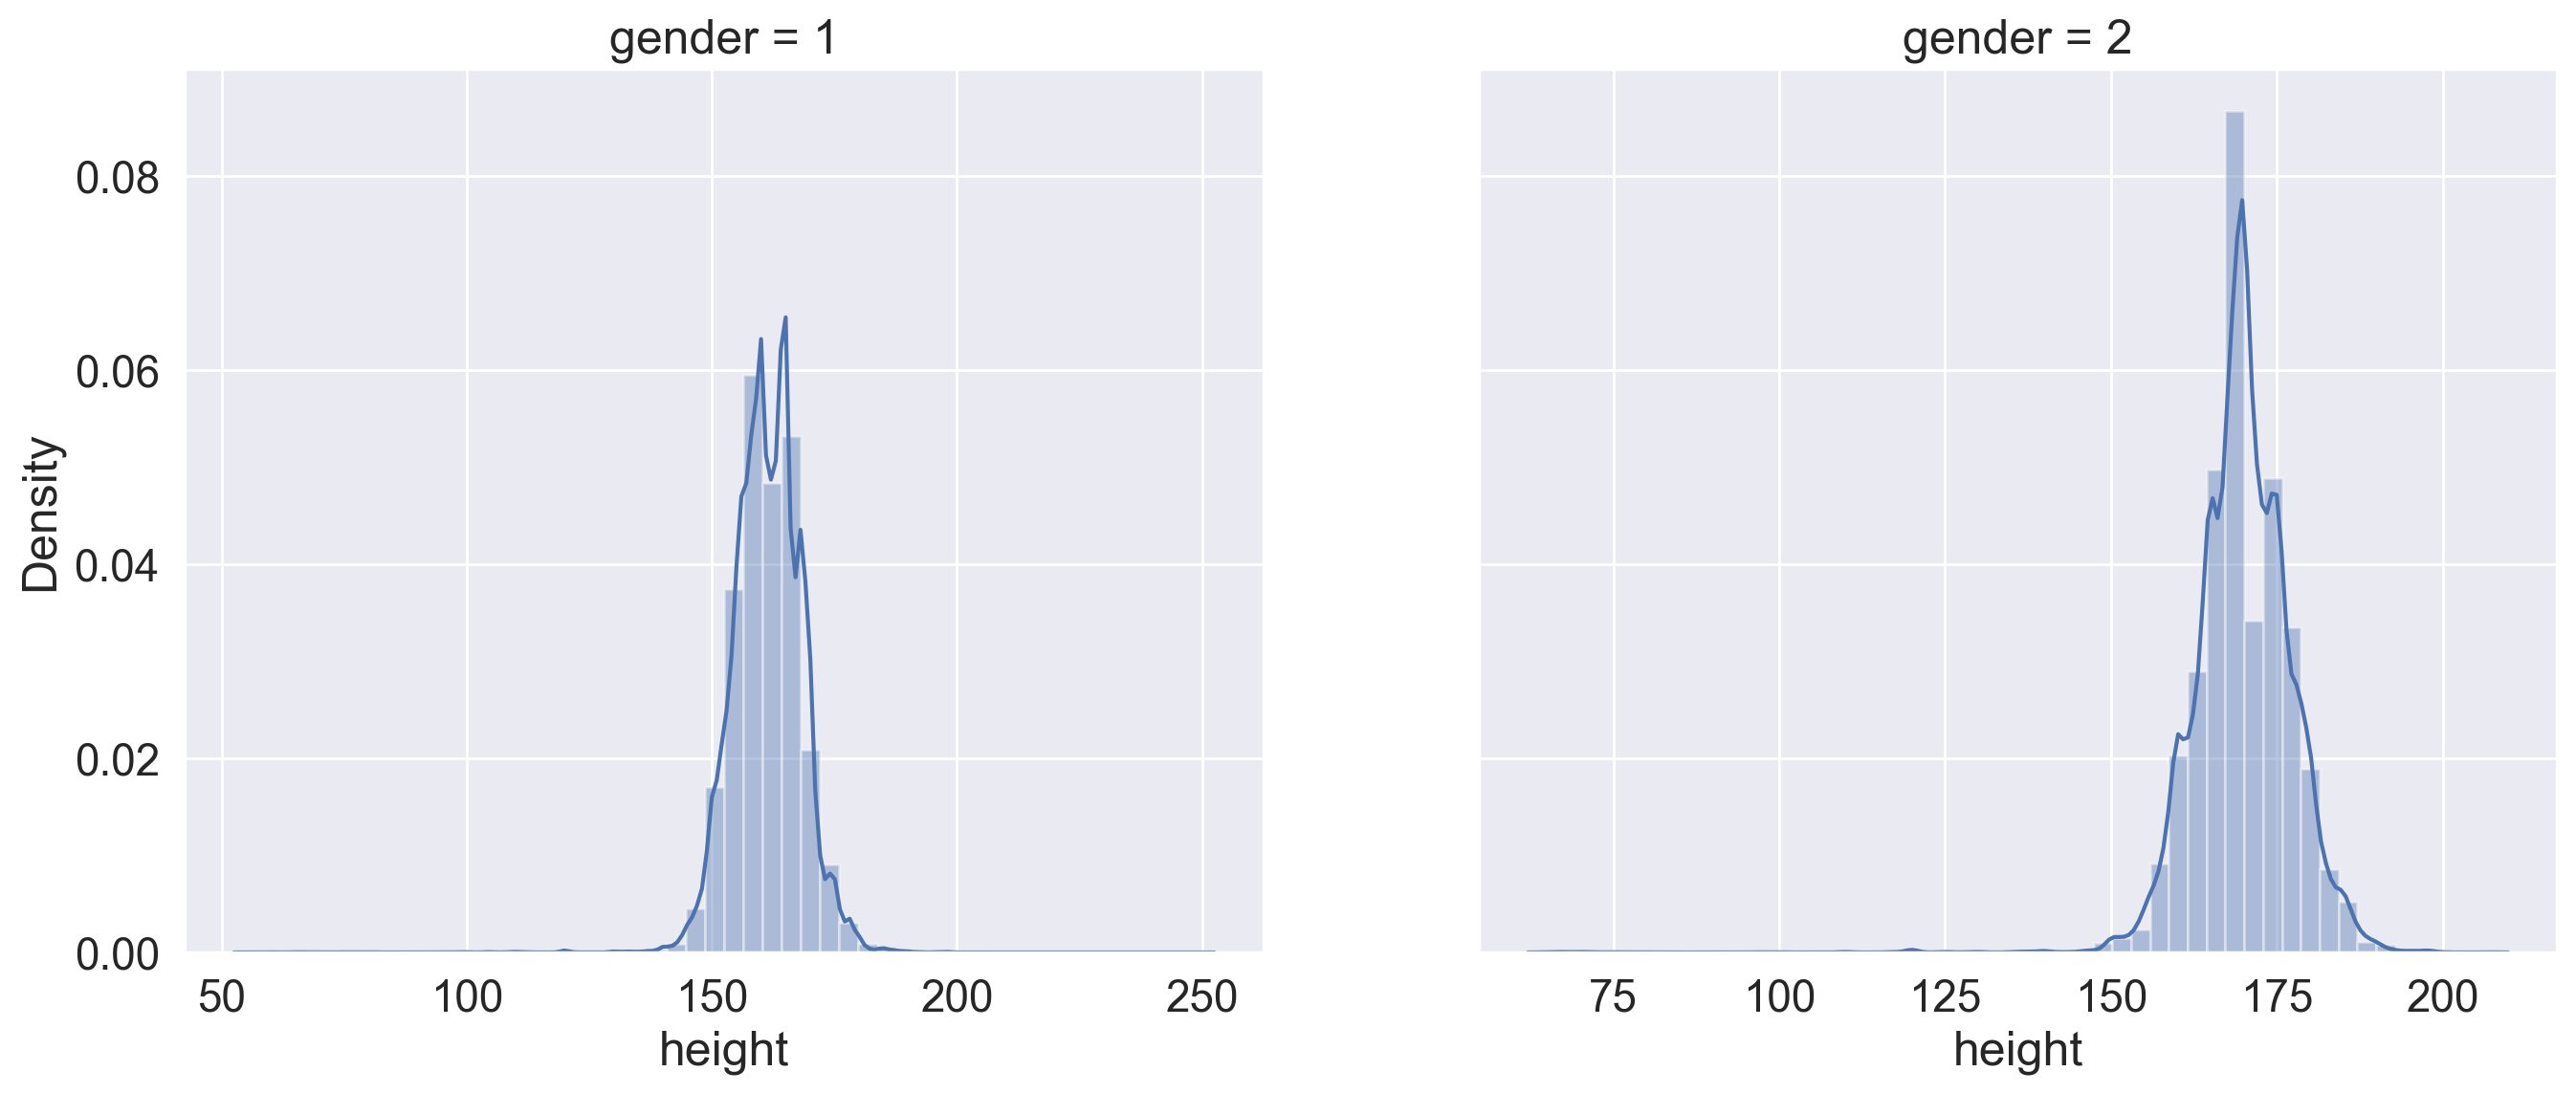

In [8]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
df_gender_1 = df[df['gender'] == 1]
sns.distplot(df_gender_1["height"], ax=axes[0]).set_title('gender = 1');
df_gender_2 = df[df['gender'] == 2]
sns.distplot(df_gender_2["height"], ax=axes[1]).set_title('gender = 2');

As seen from the plots above, gender #2 tends to be taller. So gender #2 must be men.

In [9]:
df["gender"].value_counts()

1    45530
2    24470
Name: gender, dtype: int64

There are 24470 men and 45530 women in the dataset

**Question 1.2. Who more often report consuming alcohol – men or women?**

In [10]:
pd.crosstab(df["gender"], df["alco"], normalize='index')

alco,0,1
gender,,
1,0.974500,0.025500
2,0.893625,0.106375


Men more often report consuming alcohol.

**Question 1.3. What's the rounded difference between the percentages of smokers among men and women?**

In [11]:
smoke_df = pd.crosstab(df["gender"], df["smoke"], normalize='index').mul(100)
smoke_df.loc["Total"] = smoke_df.iloc[1] - smoke_df.iloc[0]
display(smoke_df)

smoke,0,1
gender,,
1,98.214364,1.785636
2,78.111974,21.888026
Total,-20.102390,20.102390


The rounded difference between the percentages of smokers among men and women is 20%.
Men smoke more often.

**Question 1.4. What's the rounded difference between median values of age (in months) for non-smokers and smokers? You'll need to figure out the units of feature `age` in this dataset.**

In [12]:
diff = (df[(df['smoke'] == 0)]["age"].median()-df[(df['smoke'] == 1)]["age"].median())/30
print(diff)

19.9


## 1.2. Risk maps
### Task:

On the website for the European Society of Cardiology, a [SCORE scale](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts) is provided. It is used for calculating the risk of death from a cardiovascular decease in the next 10 years.


**Question 1.5. Calculate fractions of ill people (with CVD) in the two groups of people described in the task. What's the ratio of these two fractions?**

In [13]:
age_years = (df["age"]/365)

df.insert(loc=len(df.columns), column="age_years", value=age_years)
df['age_years'] = df['age_years'].round()
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.0
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52.0
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.0
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48.0


In [14]:
df_from_60_to_64 = df[(df['age_years']<=64) & (df['age_years']>=60)]
df_from_60_to_64.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,60.0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,61.0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1,62.0
10,15,22530,1,169,80.0,120,80,1,1,0,0,1,0,62.0
19,29,21755,2,162,56.0,120,70,1,1,1,0,1,0,60.0


In [15]:
smoking_old_men = df[
    (df["gender"] == 2)
    & (df["age_years"] >= 60)
    & (df["age_years"] < 65)
    & (df["smoke"] == 1)
]

In [16]:
smoking_old_men[
    (smoking_old_men["cholesterol"] == 1) & (smoking_old_men["ap_hi"] < 120)
]["cardio"].mean()

0.2564102564102564

In [17]:
smoking_old_men[
    (smoking_old_men["cholesterol"] == 3)
    & (smoking_old_men["ap_hi"] >= 160)
    & (smoking_old_men["ap_hi"] < 180)
]["cardio"].mean()

0.8636363636363636

### Task:

Create a new feature – BMI ([Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index)). To do this, divide weight in kilograms by the square of the height in meters. Normal BMI values are said to be from 18.5 to 25.

In [18]:
bmi = (df["weight"])/((df["height"]/100)**2)

df.insert(loc=len(df.columns), column="bmi", value=bmi)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.0,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.0,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52.0,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.0,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48.0,23.011177


**Question 1.6. Choose the correct statements:**

1. Median BMI in the sample is within boundaries of normal values.
2. Women's BMI is on average higher then men's.
3. Healthy people have higher median BMI than ill people.
4. In the segment of healthy and non-drinking men BMI is closer to the norm than in the segment of healthy and non-drinking women

In [19]:
df['bmi'].median()

26.374068120774975

Median BMI in the sample is not within boundaries of normal values.  Normal BMI values are said to be from 18.5 to 25. Median BMI in the sample is 26.3.

In [20]:
df_gender_1 = df[df['gender'] == 1]
df_gender_1_bmi = df_gender_1['bmi'].mean()
print(f'Women BMI is {df_gender_1_bmi}')

df_gender_2 = df[df['gender'] == 2]
df_gender_2_bmi = df_gender_2['bmi'].mean()
print(f'Men BMI is {df_gender_2_bmi}')

Women BMI is 27.98758344183285
Men BMI is 26.754442357289356


Women's BMI is on average higher then men's.

In [21]:
df_healthy = df[df['cardio'] == 0]
df_healthy_bmi = df_healthy['bmi'].median()
print(f'Healthy people median bmi is {df_healthy_bmi}')

df_ill = df[df['cardio'] == 1]
df_ill_bmi = df_ill['bmi'].median()
print(f'Ill people median bmi is {df_ill_bmi}')

Healthy people median bmi is 25.476660092044707
Ill people median bmi is 27.47138397502601


Healthy people have lower median BMI than ill people.

In [22]:
df_healthy_and_non_drinking_men = df[(df['cardio'] == 0) & (df['smoke'] == 0) & (df['gender'] == 2)]
df_healthy_and_non_drinking_men_bmi = df_healthy_and_non_drinking_men['bmi'].mean()
print(f'Healthy and non-drinking men mean BMI is {df_healthy_and_non_drinking_men_bmi}')

df_healthy_and_non_drinking_women = df[(df['cardio'] == 0) & (df['smoke'] == 0) & (df['gender'] == 1)]
df_healthy_and_non_drinking_women_bmi = df_healthy_and_non_drinking_women['bmi'].mean()
print(f'Healthy and non-drinking women mean BMI is {df_healthy_and_non_drinking_women_bmi}')

Healthy and non-drinking men mean BMI is 25.92766901879983
Healthy and non-drinking women mean BMI is 26.887217095905964


In the segment of healthy and non-drinking men BMI is closer to the norm than in the segment of healthy and non-drinking women.

### Task:
We can see that the data is not perfect. It contains "dirt" and inaccuracies. We'll see this better as we visualize the data.

Filter out the following patient segments (we consider these as erroneous data)

- diastolic pressure is higher than systolic
- height is strictly less than 2.5 percentile (Use `pd.Series.quantile` to compute this value. If you are not familiar with the function, please read the docs.)
- height is strictly more than 97.5 percentile
- weight is strictly less than 2.5 percentile
- weight is strictly more than 97.5 percentile

In [23]:
print("Dataset size: ", df.shape)
rows_before_filtering = df.shape[0]

Dataset size:  (70000, 15)


In [24]:
df = df.drop(df[(df["ap_lo"] > df["ap_hi"]) |
             (df["height"] < df["height"].quantile(q=0.025)) |
             (df["height"] > df["height"].quantile(q=0.975)) |
             (df["weight"] < df["weight"].quantile(q=0.025)) |
             (df["weight"] > df["weight"].quantile(q=0.975))].index)

**Question 1.7. What percent of the original data (rounded) did we filter out in the previous step?**

In [25]:
print("Dataset size after cleaning data: ", df.shape)

Dataset size after cleaning data:  (63259, 15)


In [26]:
rows_after_filtering = df.shape[0]
filtered_data_percentage = ((rows_before_filtering - rows_after_filtering)/rows_before_filtering)*100
print(f'{filtered_data_percentage}% of the original data was filtered.')

9.629999999999999% of the original data was filtered.


### Task:

Plot a correlation matrix using [`heatmap()`](http://seaborn.pydata.org/generated/seaborn.heatmap.html). You can create the matrix using the standard `pandas` tools with the default parameters.

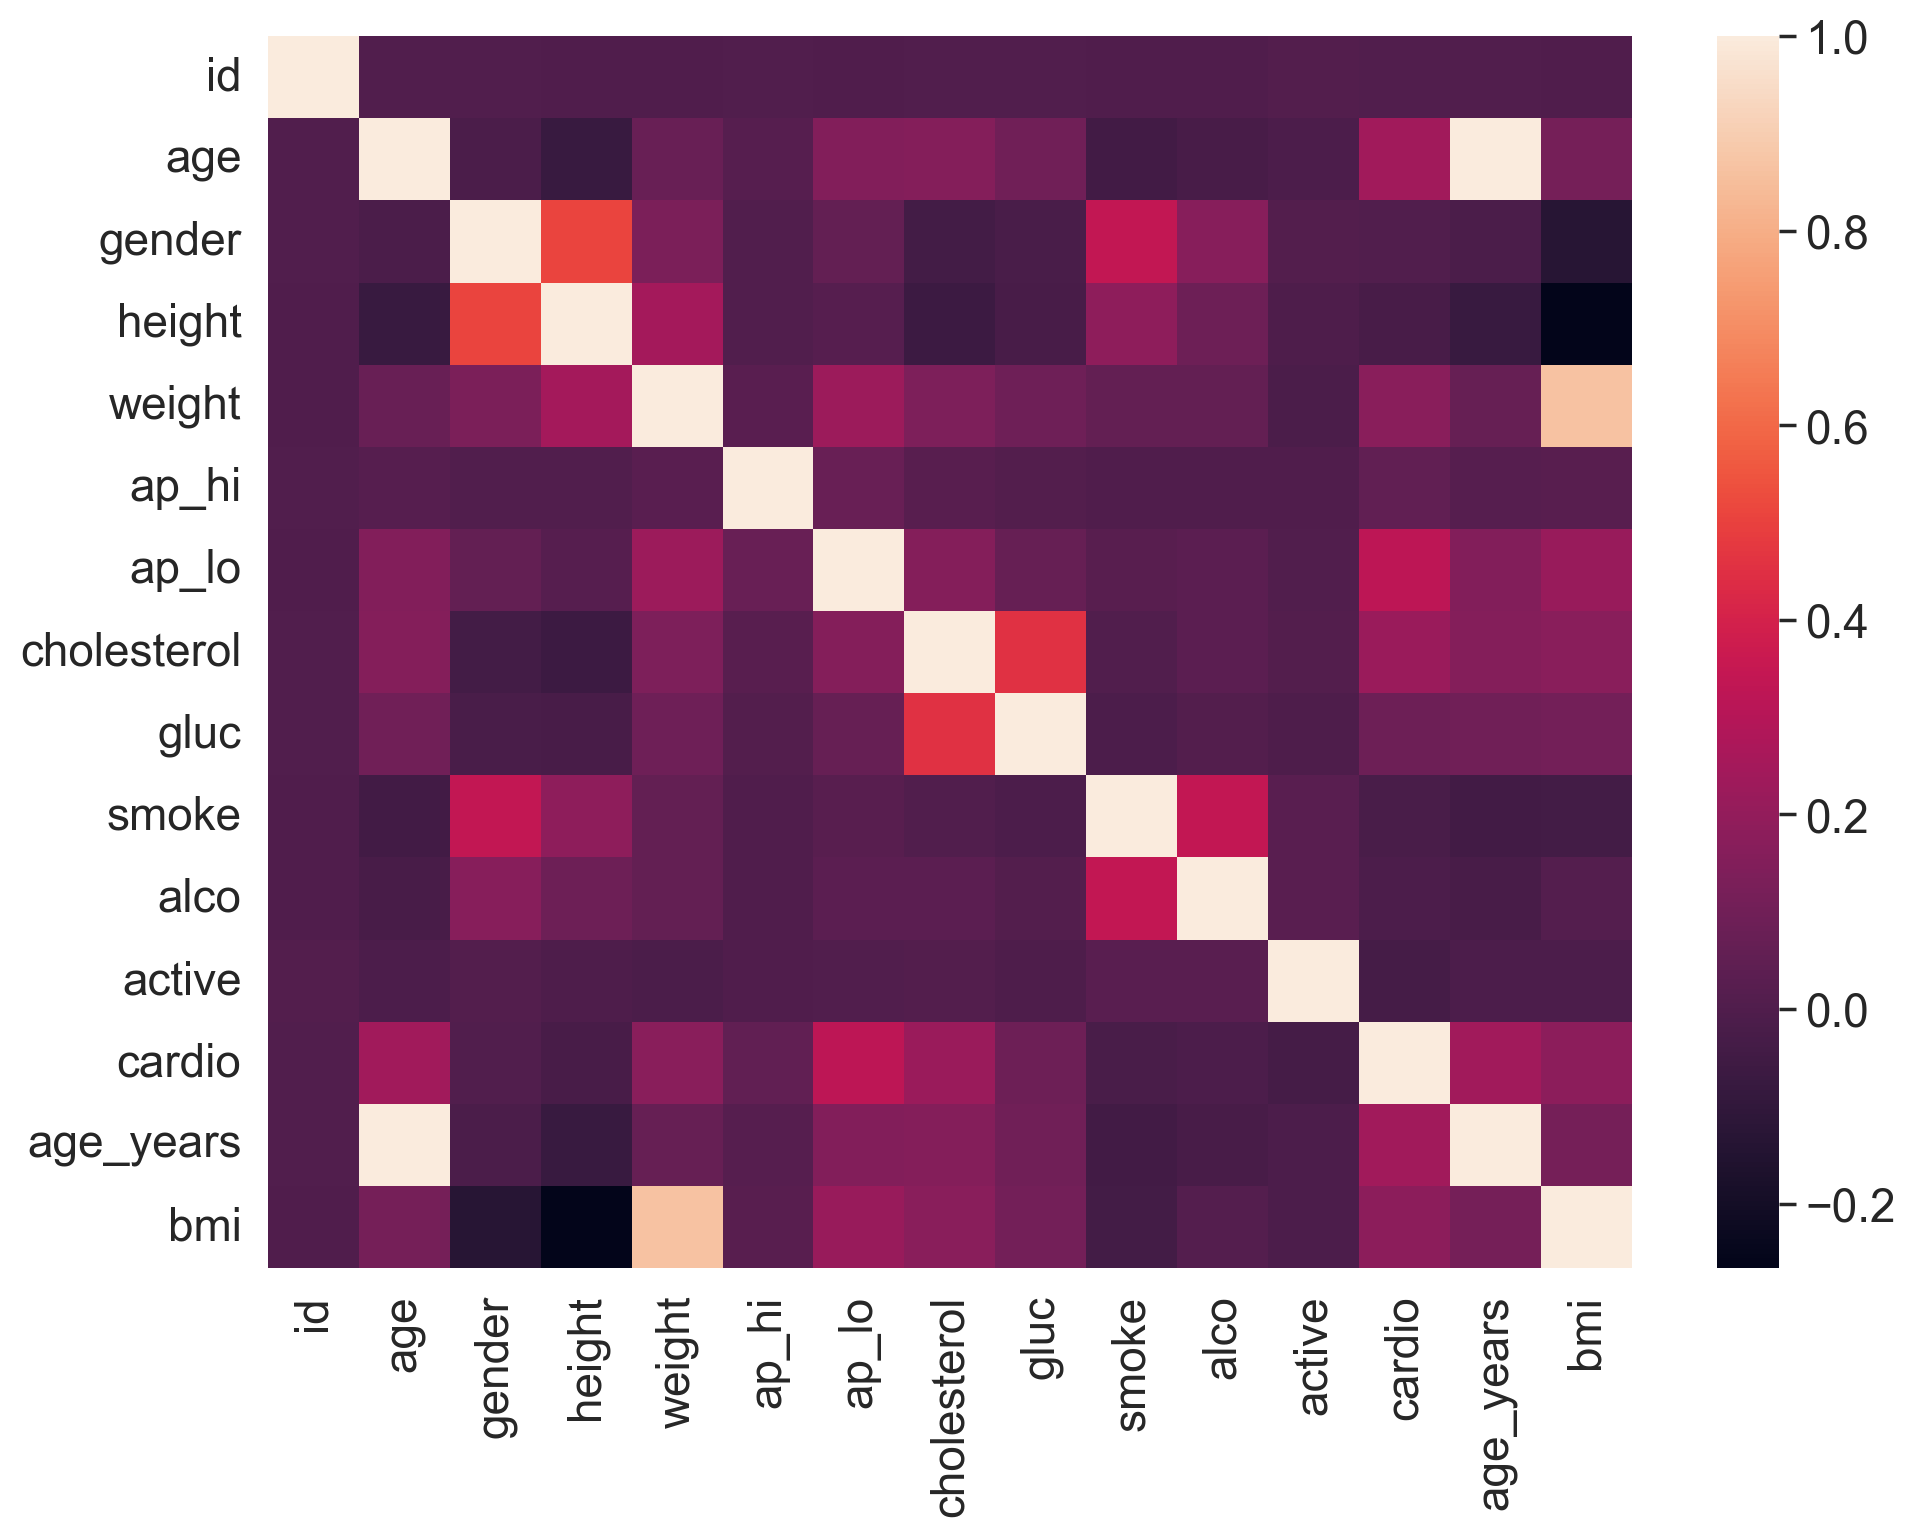

In [27]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix);

**Question 2.1.** Which pair of features has the strongest Pearson's correlation with the *gender* feature?

Height and Smoke has the strongest Pearson's correlation with the gender feature considering data from the original dataset.

### Task:

Calculate and plot a correlation matrix using the [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).

In [28]:
spearman_corr = df.corr(numeric_only=True, method='spearman')

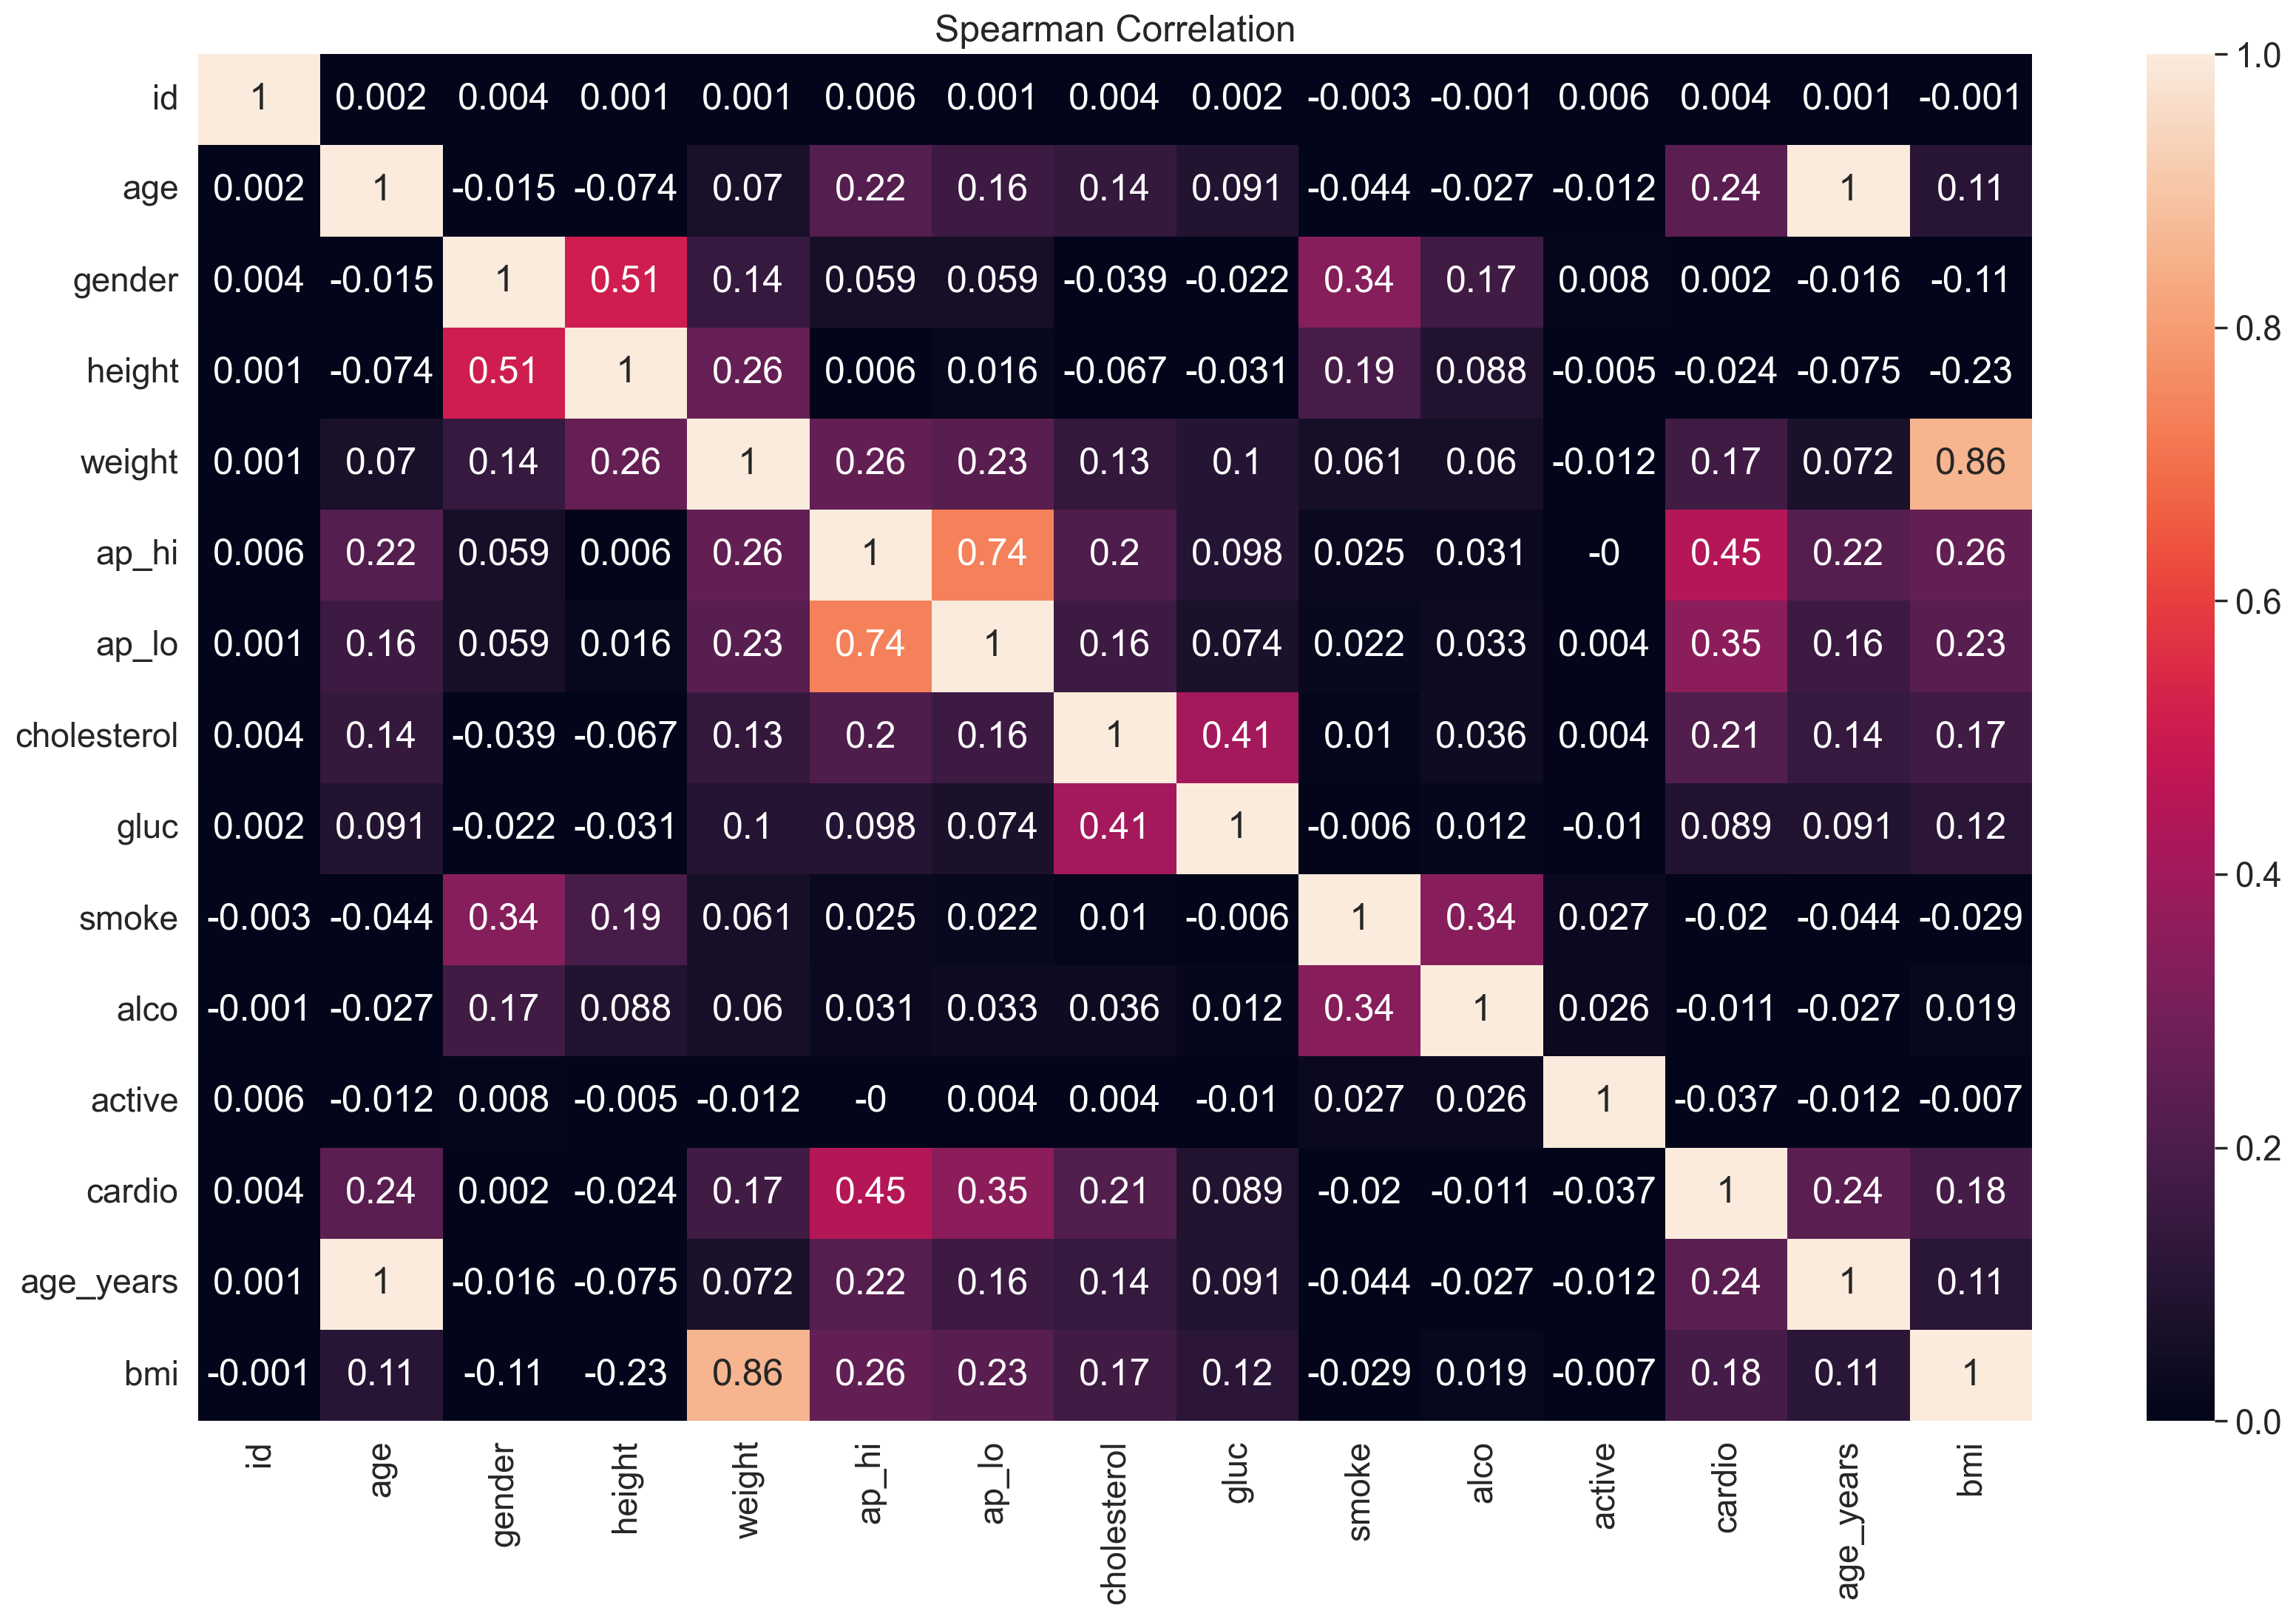

In [29]:
rounded_spearman_corr = spearman_corr.round(decimals=3)
plt.figure(figsize=(20,12))
sns.heatmap(rounded_spearman_corr, vmin=0, vmax=1, annot=True);
plt.title("Spearman Correlation");

**Question 2.2.** Which pair of features has the strongest Spearman rank correlation?

ap_hi and ap_lo has the strongest Spearman rank correlation considering data from the original dataset..

### Task:

Create a *count plot* using [`countplot()`](http://seaborn.pydata.org/generated/seaborn.countplot.html) with the age on the *X* axis and the number of people on the *Y* axis. Your resulting plot should have two columns for each age, corresponding to the number of people for each *cardio* class of that age.

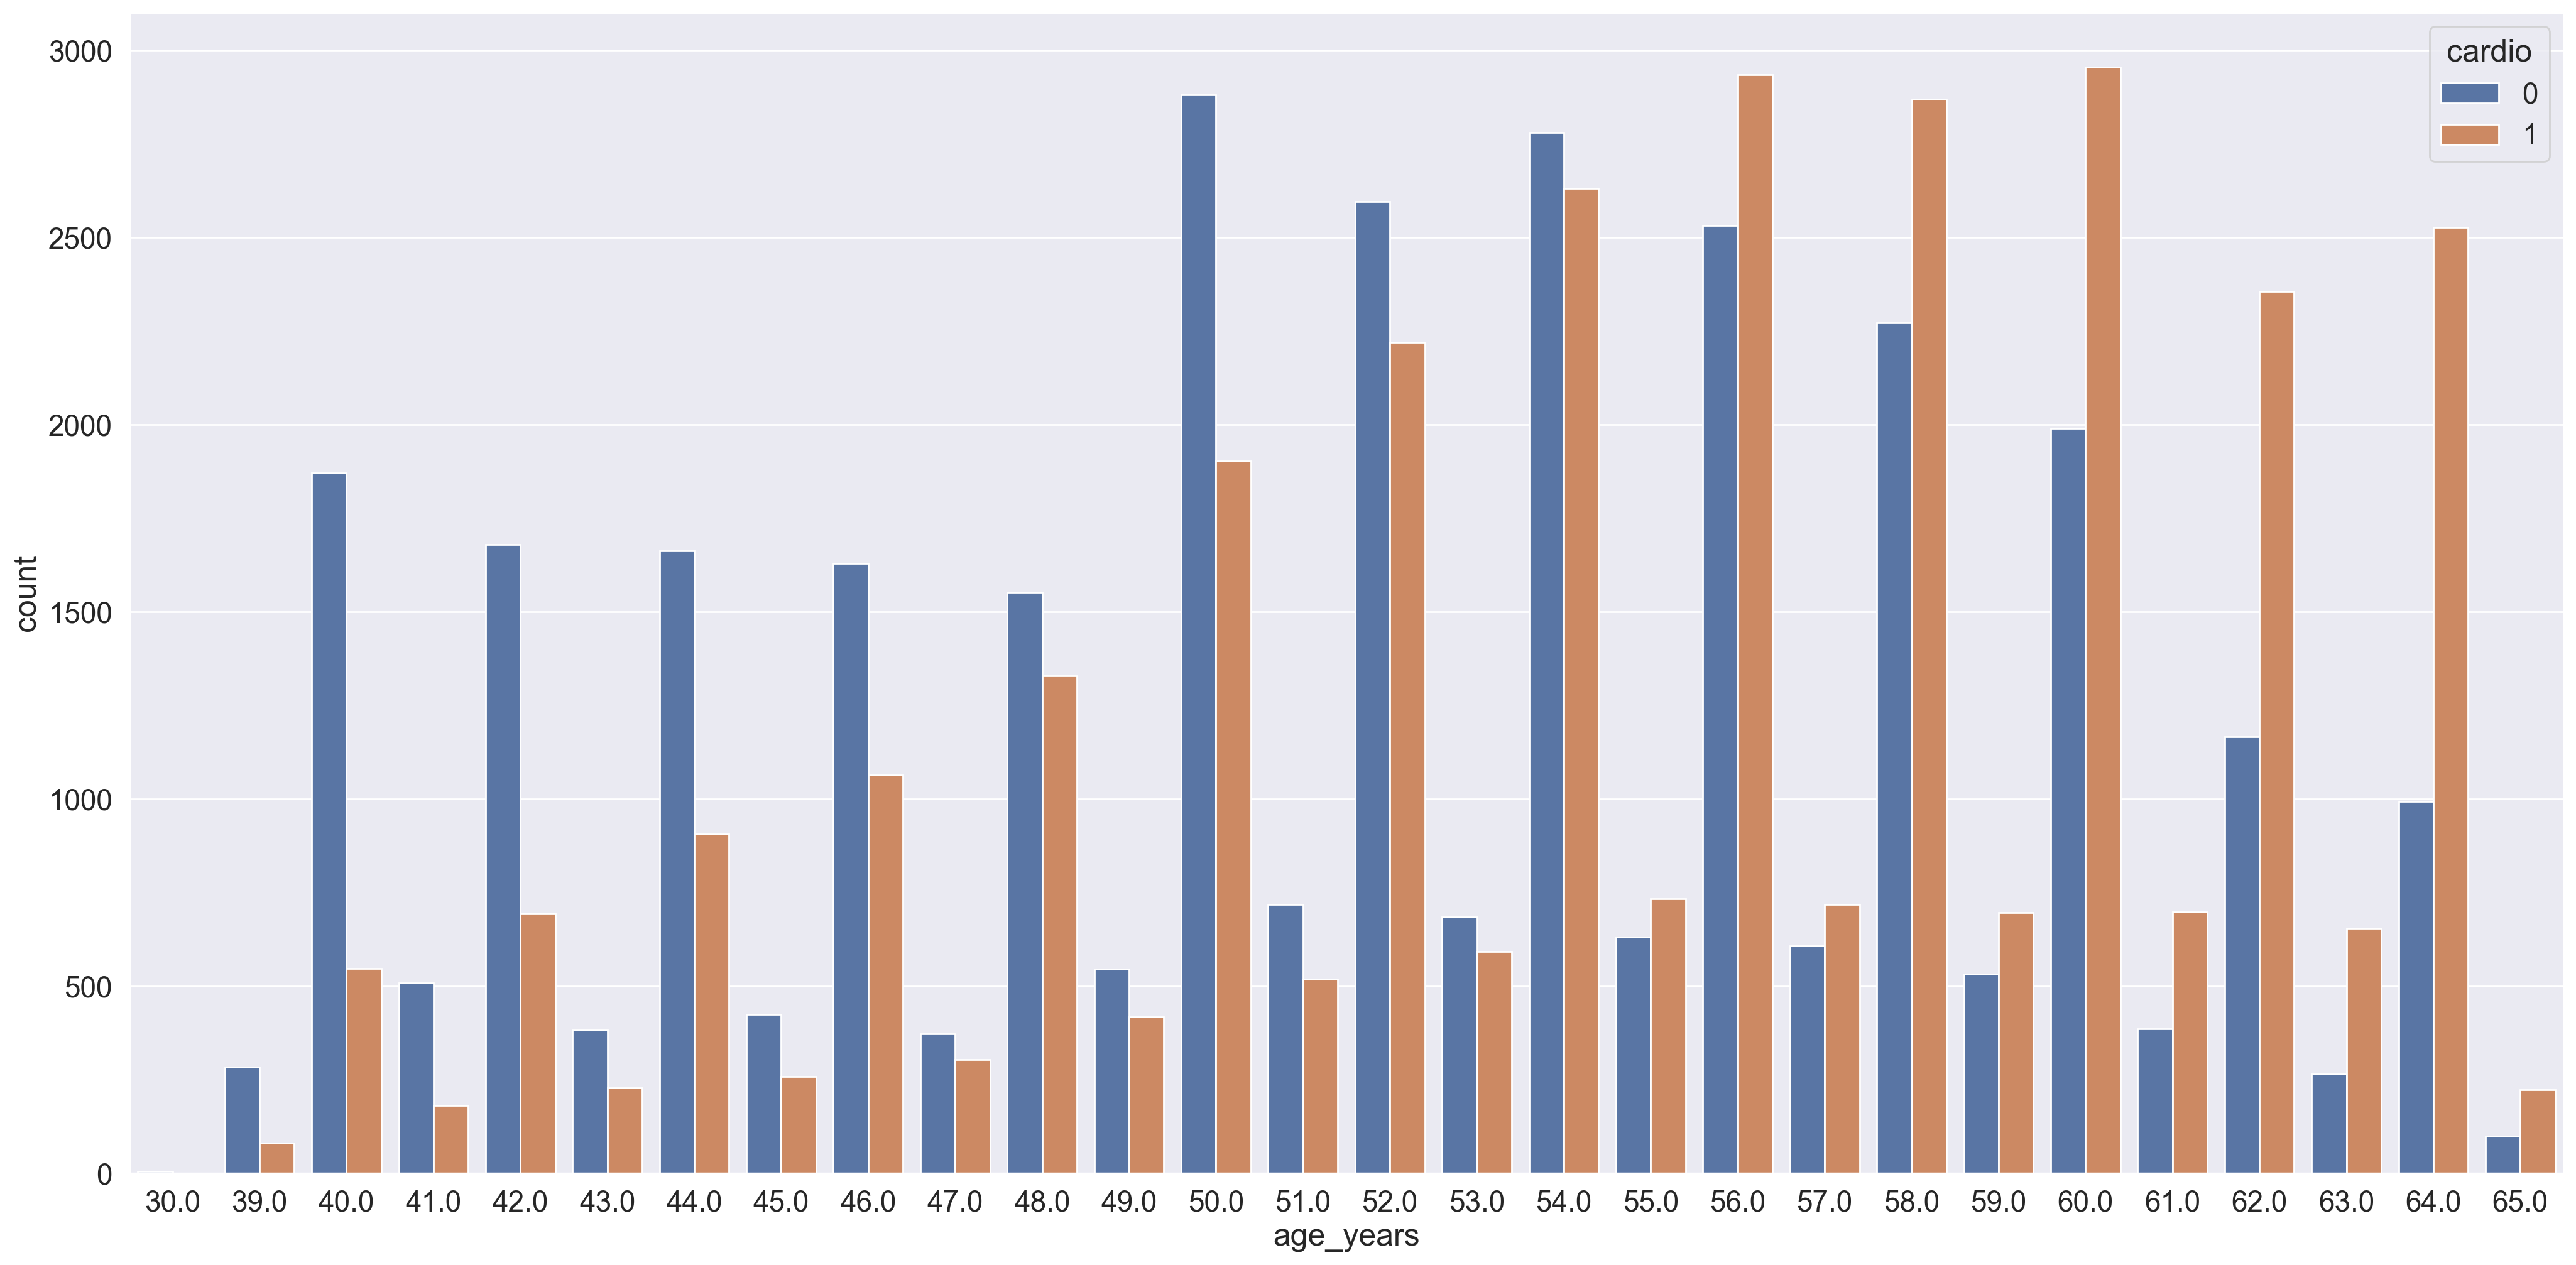

In [30]:
plt.figure(figsize=(25,12))
sns.countplot(x="age_years", hue="cardio", data=df);